# Configs

In [1]:
splitPartCount = 5
splitSeed = 27
hoursPerWindow = 1

# Load data

In [2]:
from utils.prepare_data import getMonitoredPatients

patients = getMonitoredPatients()

In [3]:
# # remove patients with positive tag in first 12 hours

from pandas import Timedelta


patients.removePatientAkiEarly(Timedelta(hours=12))

82

In [4]:
print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

Total  1124
AKI  392
Ratio  0.3487544483985765


# LSTM

### Seperate static and dynamic

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class LSTMModel(nn.Module):
    def __init__(self, inSize):
        super(LSTMModel, self).__init__()

        self.inSize = inSize

        self.lstm = nn.LSTM(
            input_size=inSize, hidden_size=64, batch_first=True, dropout=0.5
        )
        self.fc1 = nn.Linear(64, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        ## dropout
        x = x[:, -1, :]
        x = F.dropout(x, p=0.5)
        x = self.fc1(x)

        return x

In [6]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_


def train(
    model,
    device,
    trainLoader,
    valLoader,
    criterion,
    optimizer,
    epochs=20,
    earlyStopping=5,
):
    model.to(device)

    optimScheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=2)

    # early stopping
    bestValLoss = float("inf")
    bestModelState = None
    patience = 0

    trainLosses = []
    valLosses = []

    for epoch in range(epochs):
        model.train()
        trainLoss = 0

        for batchX, batchY in trainLoader:
            batchX, batchY = batchX.to(device), batchY.to(device)

            outputs = model(batchX)
            loss = criterion(outputs, batchY)

            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            trainLoss += loss.item() * batchX.size(0)

        trainLoss /= len(trainLoader.dataset)
        trainLosses.append(trainLoss)

        # validation
        model.eval()
        valLoss = 0

        with torch.no_grad():
            for batchX, batchY in valLoader:
                batchX, batchY = batchX.to(device), batchY.to(device)

                outputs = model(batchX)
                loss = criterion(outputs, batchY)

                valLoss += loss.item() * batchX.size(0)

        valLoss /= len(valLoader.dataset)
        valLosses.append(valLoss)
        
        optimScheduler.step(valLoss, epoch)

        if valLoss < bestValLoss:
            bestValLoss = valLoss
            bestModelState = model.state_dict()
            patience = 0
        else:
            patience += 1

        print(
            f"Epoch {epoch+1}/{epochs} Train Loss: {trainLoss:.4f} Val Loss: {valLoss:.4f}"
        )

        if patience > earlyStopping:
            break

    model.load_state_dict(bestModelState)
    return model, trainLosses, valLosses


def predTest(model, device, testLoader):
    model.eval()

    predProbas = []
    actuals = []

    with torch.no_grad():
        for batchX, batchY in testLoader:
            batchX, batchY = batchX.to(device), batchY.to(device)

            outputs = model(batchX)
            probas = torch.sigmoid(outputs)
            predProbas.extend(probas.cpu().numpy())
            actuals.extend(batchY.cpu().numpy())

    return predProbas, actuals

In [7]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
)
from utils.class_voter import combineProbas
from utils.prepare_data import (
    DeepLearningDataPreparer,
    trainValTestPatients,
)
import numpy as np


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
specificity_score_list = []
sensitivity_score_list = []
auc_pr_list = []

train_loss_list = []
val_loss_list = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batchSize = 64

for i, (trainValGenerator, testPatients) in enumerate(
    trainValTestPatients(patients, splitSeed)
):
    models = []
    probas = []
    for ii, (trainPatients, valPatients) in enumerate(trainValGenerator):
        preparer = DeepLearningDataPreparer(
            hoursPerWindows=hoursPerWindow,
            fromHour=0,
            toHour=12,
        )

        (
            (npTrainX, staticTrainX, trainY),
            (npValX, staticValX, valY),
            (npTestX, staticTestX, testY),
        ) = preparer.trainValTest(trainPatients, valPatients, testPatients)

        neg, pos = np.bincount(trainY)
        weight0 = (1 / neg) * (len(trainY)) / 2.0
        weight1 = (1 / pos) * (len(trainY)) / 2.0
        weight = {0: weight0, 1: weight1}

        # expand static data to be same size as time series data
        staticTrainX = np.expand_dims(staticTrainX, axis=1)
        staticTrainX = np.repeat(staticTrainX, npTrainX.shape[1], axis=1)

        staticTestX = np.expand_dims(staticTestX, axis=1)
        staticTestX = np.repeat(staticTestX, npTestX.shape[1], axis=1)

        staticValX = np.expand_dims(staticValX, axis=1)
        staticValX = np.repeat(staticValX, npValX.shape[1], axis=1)
        # append to npX
        npTrainX = np.concatenate([npTrainX, staticTrainX], axis=2)
        npTestX = np.concatenate([npTestX, staticTestX], axis=2)
        npValX = np.concatenate([npValX, staticValX], axis=2)

        # create data loader
        trainLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npTrainX).float(),
                torch.tensor(trainY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=True,
        )
        valLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npValX).float(),
                torch.tensor(valY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=False,
        )
        testLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npTestX).float(),
                torch.tensor(testY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=False,
        )

        model = LSTMModel(inSize=npTrainX.shape[2])
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        _, trainLosses, valLosses = train(
            model, device, trainLoader, valLoader, criterion, optimizer, epochs=20
        )

        models.append(model)
        train_loss_list.append(trainLosses)
        val_loss_list.append(valLosses)

        predProbas, _ = predTest(model, device, testLoader)
        probas.append(predProbas)

    # calculate final probas, auc, accuracy, precision, recal
    finalYProbas = np.apply_along_axis(combineProbas, 0, np.array(probas))
    finalYPred = np.where(finalYProbas > 0.5, 1, 0)
    tn, fp, fn, tp = confusion_matrix(testY, finalYPred).ravel()
    precision_vals, recall_vals, _ = precision_recall_curve(testY, finalYProbas)

    accuracy_score_list.append(accuracy_score(testY, finalYPred))
    specificity_score_list.append(tn / (tn + fp))
    precision_score_list.append(precision_score(testY, finalYPred))
    recall_score_list.append(recall_score(testY, finalYPred))
    auc_score_list.append(roc_auc_score(testY, finalYProbas))
    auc_pr_list.append(auc(recall_vals, precision_vals))

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1370: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/20 Train Loss: 0.6581 Val Loss: 0.6276
Epoch 2/20 Train Loss: 0.5656 Val Loss: 0.5713
Epoch 3/20 Train Loss: 0.4971 Val Loss: 0.5651
Epoch 4/20 Train Loss: 0.4817 Val Loss: 0.5768
Epoch 5/20 Train Loss: 0.4672 Val Loss: 0.5655
Epoch 6/20 Train Loss: 0.4553 Val Loss: 0.5741
Epoch 7/20 Train Loss: 0.4467 Val Loss: 0.5726
Epoch 8/20 Train Loss: 0.4513 Val Loss: 0.5669
Epoch 9/20 Train Loss: 0.4430 Val Loss: 0.5667
Epoch 1/20 Train Loss: 0.6666 Val Loss: 0.6242


/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 2/20 Train Loss: 0.5876 Val Loss: 0.5470
Epoch 3/20 Train Loss: 0.5276 Val Loss: 0.5244
Epoch 4/20 Train Loss: 0.5022 Val Loss: 0.5188
Epoch 5/20 Train Loss: 0.4808 Val Loss: 0.5114
Epoch 6/20 Train Loss: 0.4612 Val Loss: 0.5129
Epoch 7/20 Train Loss: 0.4538 Val Loss: 0.5141
Epoch 8/20 Train Loss: 0.4290 Val Loss: 0.5239
Epoch 9/20 Train Loss: 0.4102 Val Loss: 0.5108
Epoch 10/20 Train Loss: 0.4135 Val Loss: 0.5218
Epoch 11/20 Train Loss: 0.4103 Val Loss: 0.5269
Epoch 12/20 Train Loss: 0.4120 Val Loss: 0.5255
Epoch 13/20 Train Loss: 0.4087 Val Loss: 0.5391
Epoch 14/20 Train Loss: 0.4067 Val Loss: 0.5285
Epoch 15/20 Train Loss: 0.4050 Val Loss: 0.5164
Epoch 1/20 Train Loss: 0.6748 Val Loss: 0.6612
Epoch 2/20 Train Loss: 0.6032 Val Loss: 0.5802
Epoch 3/20 Train Loss: 0.5463 Val Loss: 0.5126
Epoch 4/20 Train Loss: 0.5168 Val Loss: 0.4967
Epoch 5/20 Train Loss: 0.5023 Val Loss: 0.4983
Epoch 6/20 Train Loss: 0.4930 Val Loss: 0.4913
Epoch 7/20 Train Loss: 0.4743 Val Loss: 0.5027
Epoch 8

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1370: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/20 Train Loss: 0.6660 Val Loss: 0.6572
Epoch 2/20 Train Loss: 0.5792 Val Loss: 0.6049
Epoch 3/20 Train Loss: 0.5225 Val Loss: 0.5775
Epoch 4/20 Train Loss: 0.4885 Val Loss: 0.5946
Epoch 5/20 Train Loss: 0.4690 Val Loss: 0.5871
Epoch 6/20 Train Loss: 0.4478 Val Loss: 0.6044
Epoch 7/20 Train Loss: 0.4349 Val Loss: 0.5840
Epoch 8/20 Train Loss: 0.4372 Val Loss: 0.5853
Epoch 9/20 Train Loss: 0.4360 Val Loss: 0.5814
Epoch 1/20 Train Loss: 0.6574 Val Loss: 0.6268
Epoch 2/20 Train Loss: 0.5852 Val Loss: 0.5603
Epoch 3/20 Train Loss: 0.5306 Val Loss: 0.5292
Epoch 4/20 Train Loss: 0.4981 Val Loss: 0.5173
Epoch 5/20 Train Loss: 0.4794 Val Loss: 0.5043
Epoch 6/20 Train Loss: 0.4616 Val Loss: 0.5069
Epoch 7/20 Train Loss: 0.4524 Val Loss: 0.5051
Epoch 8/20 Train Loss: 0.4339 Val Loss: 0.5049
Epoch 9/20 Train Loss: 0.4169 Val Loss: 0.5190
Epoch 10/20 Train Loss: 0.4171 Val Loss: 0.5141
Epoch 11/20 Train Loss: 0.4153 Val Loss: 0.4852
Epoch 12/20 Train Loss: 0.4075 Val Loss: 0.4866
Epoch 13/2

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1370: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/20 Train Loss: 0.6851 Val Loss: 0.6628
Epoch 2/20 Train Loss: 0.5827 Val Loss: 0.5795
Epoch 3/20 Train Loss: 0.5147 Val Loss: 0.5461
Epoch 4/20 Train Loss: 0.4994 Val Loss: 0.5616
Epoch 5/20 Train Loss: 0.4790 Val Loss: 0.5586
Epoch 6/20 Train Loss: 0.4606 Val Loss: 0.5549
Epoch 7/20 Train Loss: 0.4550 Val Loss: 0.5675
Epoch 8/20 Train Loss: 0.4543 Val Loss: 0.5600
Epoch 9/20 Train Loss: 0.4510 Val Loss: 0.5661
Epoch 1/20 Train Loss: 0.6780 Val Loss: 0.6434
Epoch 2/20 Train Loss: 0.5881 Val Loss: 0.5658
Epoch 3/20 Train Loss: 0.5223 Val Loss: 0.5214
Epoch 4/20 Train Loss: 0.4979 Val Loss: 0.5376
Epoch 5/20 Train Loss: 0.4759 Val Loss: 0.5313
Epoch 6/20 Train Loss: 0.4652 Val Loss: 0.5355
Epoch 7/20 Train Loss: 0.4501 Val Loss: 0.5163
Epoch 8/20 Train Loss: 0.4505 Val Loss: 0.5307
Epoch 9/20 Train Loss: 0.4439 Val Loss: 0.5325
Epoch 10/20 Train Loss: 0.4439 Val Loss: 0.5437
Epoch 11/20 Train Loss: 0.4385 Val Loss: 0.5314
Epoch 12/20 Train Loss: 0.4405 Val Loss: 0.5294
Epoch 13/2

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1370: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/20 Train Loss: 0.5907 Val Loss: 0.5838
Epoch 3/20 Train Loss: 0.5307 Val Loss: 0.5382
Epoch 4/20 Train Loss: 0.4957 Val Loss: 0.5396
Epoch 5/20 Train Loss: 0.4801 Val Loss: 0.5243
Epoch 6/20 Train Loss: 0.4740 Val Loss: 0.5247
Epoch 7/20 Train Loss: 0.4578 Val Loss: 0.5261
Epoch 8/20 Train Loss: 0.4404 Val Loss: 0.5234
Epoch 9/20 Train Loss: 0.4302 Val Loss: 0.5284
Epoch 10/20 Train Loss: 0.4226 Val Loss: 0.5164
Epoch 11/20 Train Loss: 0.3966 Val Loss: 0.5279
Epoch 12/20 Train Loss: 0.3890 Val Loss: 0.5324
Epoch 13/20 Train Loss: 0.3639 Val Loss: 0.5479
Epoch 14/20 Train Loss: 0.3370 Val Loss: 0.5405
Epoch 15/20 Train Loss: 0.3424 Val Loss: 0.5300
Epoch 16/20 Train Loss: 0.3406 Val Loss: 0.5374
Epoch 1/20 Train Loss: 0.6559 Val Loss: 0.6394
Epoch 2/20 Train Loss: 0.5764 Val Loss: 0.5727
Epoch 3/20 Train Loss: 0.5201 Val Loss: 0.5404
Epoch 4/20 Train Loss: 0.5002 Val Loss: 0.5314
Epoch 5/20 Train Loss: 0.4783 Val Loss: 0.5376
Epoch 6/20 Train Loss: 0.4531 Val Loss: 0.5388
Epoch 

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1370: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/20 Train Loss: 0.6413 Val Loss: 0.6320
Epoch 2/20 Train Loss: 0.5563 Val Loss: 0.5727
Epoch 3/20 Train Loss: 0.5015 Val Loss: 0.5346
Epoch 4/20 Train Loss: 0.4716 Val Loss: 0.5343
Epoch 5/20 Train Loss: 0.4612 Val Loss: 0.5312
Epoch 6/20 Train Loss: 0.4487 Val Loss: 0.5373
Epoch 7/20 Train Loss: 0.4363 Val Loss: 0.5313
Epoch 8/20 Train Loss: 0.4213 Val Loss: 0.5349
Epoch 9/20 Train Loss: 0.4065 Val Loss: 0.5418
Epoch 10/20 Train Loss: 0.4018 Val Loss: 0.5557
Epoch 11/20 Train Loss: 0.3983 Val Loss: 0.5393
Epoch 1/20 Train Loss: 0.6611 Val Loss: 0.6248
Epoch 2/20 Train Loss: 0.5721 Val Loss: 0.5479
Epoch 3/20 Train Loss: 0.5148 Val Loss: 0.5017
Epoch 4/20 Train Loss: 0.4965 Val Loss: 0.4799
Epoch 5/20 Train Loss: 0.4881 Val Loss: 0.4894
Epoch 6/20 Train Loss: 0.4641 Val Loss: 0.4947
Epoch 7/20 Train Loss: 0.4479 Val Loss: 0.4893
Epoch 8/20 Train Loss: 0.4288 Val Loss: 0.4842
Epoch 9/20 Train Loss: 0.4302 Val Loss: 0.4818
Epoch 10/20 Train Loss: 0.4339 Val Loss: 0.5021
Epoch 1/20

In [8]:
print(f"AUC: {np.mean(auc_score_list)} +- {np.std(auc_score_list)}", auc_score_list)
print(f"Accuracy: {np.mean(accuracy_score_list)} +- {np.std(accuracy_score_list)}", accuracy_score_list)
print(f"Specificity: {np.mean(specificity_score_list)} +- {np.std(specificity_score_list)}", specificity_score_list)
print(f"Precision: {np.mean(precision_score_list)} +- {np.std(precision_score_list)}", precision_score_list)
print(f"Recall: {np.mean(recall_score_list)} +- {np.std(recall_score_list)}", recall_score_list)
print(f"AUC PR: {np.mean(auc_pr_list)} +- {np.std(auc_pr_list)}", auc_pr_list)

AUC: 0.8137243634432071 +- 0.014530624825455158 [np.float64(0.8297575440432583), np.float64(0.8036804465375895), np.float64(0.8244321137506503), np.float64(0.8202705045951101), np.float64(0.7904812082894275)]
Accuracy: 0.7615396825396825 +- 0.022194290836370582 [0.7733333333333333, 0.7377777777777778, 0.7866666666666666, 0.7777777777777778, 0.7321428571428571]
Specificity: 0.8100922560805144 +- 0.0345186921860485 [np.float64(0.8435374149659864), np.float64(0.7891156462585034), np.float64(0.8424657534246576), np.float64(0.821917808219178), np.float64(0.7534246575342466)]
Precision: 0.6565053008888626 +- 0.040130358374763545 [0.684931506849315, 0.6172839506172839, 0.7012987012987013, 0.6790123456790124, 0.6]
Recall: 0.6708211619604025 +- 0.02467107369862056 [0.6410256410256411, 0.6410256410256411, 0.6835443037974683, 0.6962025316455697, 0.6923076923076923]
AUC PR: 0.6788681324769341 +- 0.02588036747530384 [np.float64(0.6803847214721646), np.float64(0.6798954678415177), np.float64(0.69246

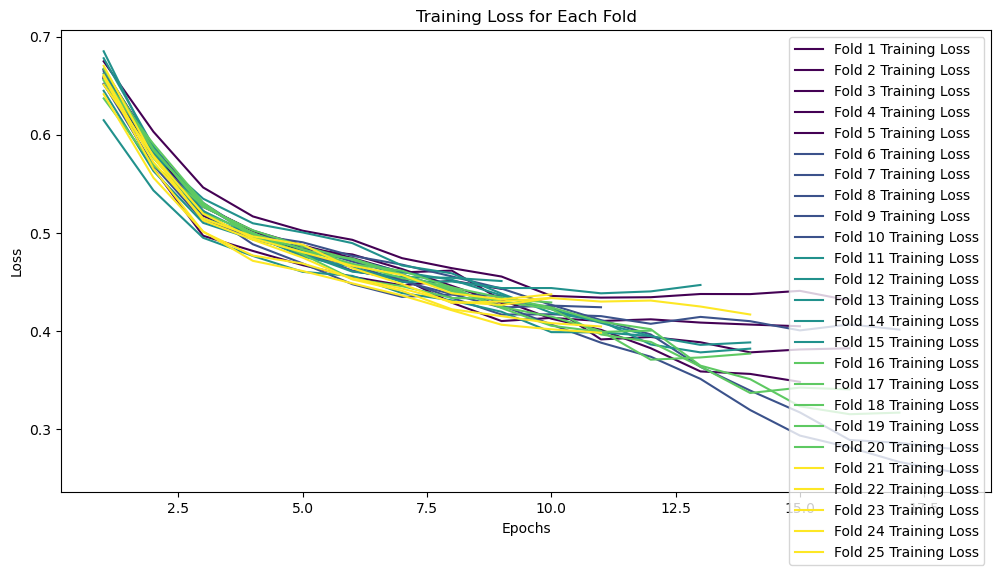

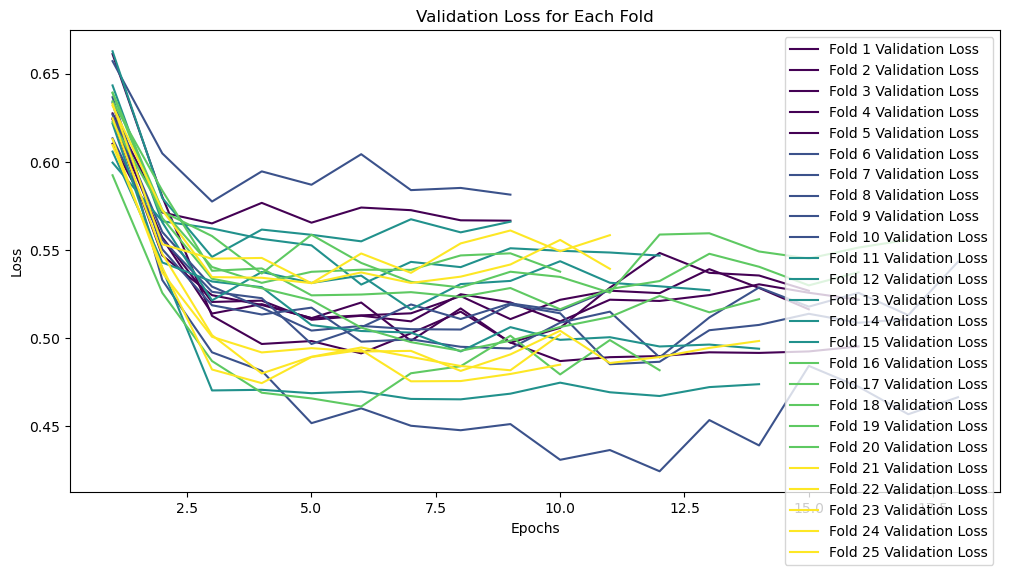

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


plt.figure(figsize=(12, 6))
colors = cm.viridis(np.linspace(0, 1, 5))
for i, train_loss in enumerate(train_loss_list):
    plt.plot(
        range(1, len(train_loss) + 1),
        train_loss,
        label=f"Fold {i+1} Training Loss",
        color=colors[i // 5],
    )
plt.title("Training Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/lstm_only_train_loss.svg")
plt.show()

# Plot the validation loss for each fold
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_loss_list):
    plt.plot(
        range(1, len(val_loss) + 1),
        val_loss,
        label=f"Fold {i+1} Validation Loss",
        color=colors[i // 5],
    )
plt.title("Validation Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()